In [3]:
# based on https://quantum.cloud.ibm.com/learning/en/courses/utility-scale-quantum-computing/quantum-phase-estimation
# see also:  https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/quantum-phase-estimation.ipynb 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Sampler
import numpy as np
from qiskit.circuit.library import QFT


3.3 Exercise
Estimate x=1/3 pi using 3 qubits for counting and a qubit for an eigenvector.

/tmp/ipykernel_27/2519595053.py:14: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(nqp, inverse=True), range(nqp))


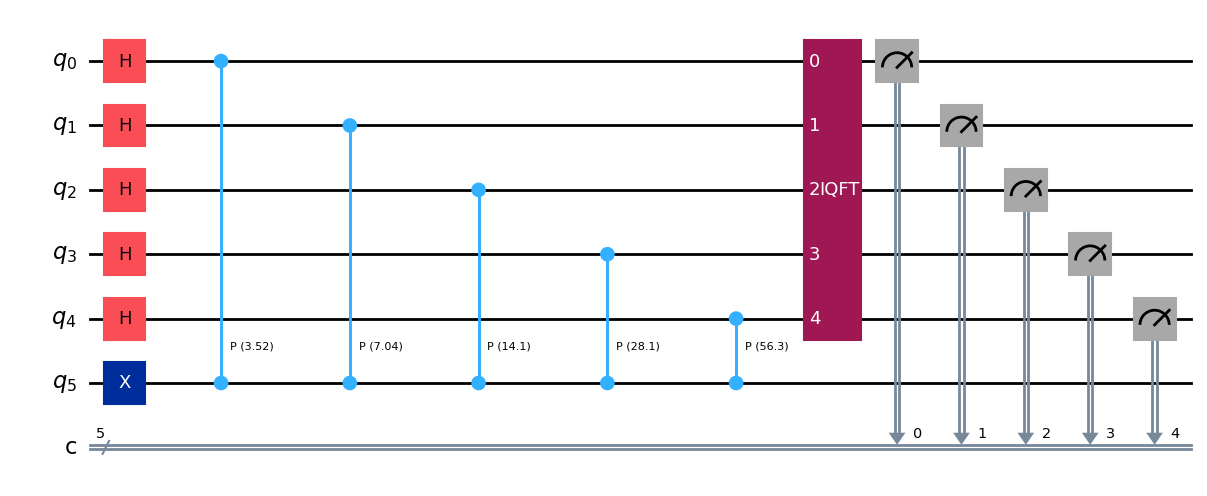

In [113]:
xtrue=0.56  # * pi the phase w want to find
nqp=5;  # phase-encoding qubits  +1 qubut for U
qc = QuantumCircuit(nqp+1,nqp)
# ...  pre pahse qubits
for i in range(nqp):  qc.h(i)
# ... set eigne state for U
qc.x(nqp)
#  add powers of unitary Q=exp( 2pi i θ)
for i in range(nqp): 
    qc.cp( xtrue* (1<<i) * 2* np.pi,i,nqp)
    #for j in range(1<<i):
    #    qc.cp( xtrue * 2*np.pi,i,nqp)
# Apply inverse QFT
qc.append(QFT(nqp, inverse=True), range(nqp))   
for n in range(nqp):
    qc.measure(n, n)
qc.draw(output="mpl")

Transpiled, ops: OrderedDict({'cp': 15, 'h': 10, 'measure': 5, 'swap': 2, 'x': 1}) 
num2q: 17 len2q: 13


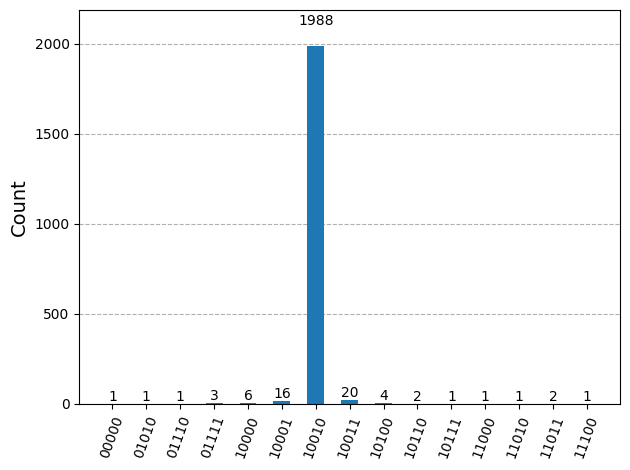

In [114]:
backend = AerSimulator()
shots = 2048
def runJob(qc,shots,backend): 
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    qcT = pm.run(qc)
    len2q=qcT.depth(filter_function=lambda x: x.operation.num_qubits == 2 )
    n2q_g=qcT.num_nonlocal_gates()
    print('Transpiled, ops:',qcT.count_ops(),'\nnum2q:',n2q_g,'len2q:',len2q)
    sampler = Sampler(mode=backend)
    job = sampler.run([qcT], shots=shots)
    result = job.result()
    countD = result[0].data.c.get_counts()
    return countD
countD=runJob(qc,shots,backend) 
plot_histogram(countD)

In [115]:
# extract x from ,measurement
def eval_x(countD):
    max_key, max_value = max(countD.items(), key=lambda x: x[1])
    print('num keys:',len(countD),max_key, max_value)
    prob=max_value/shots
    ikey=int(max_key,2)
    xrec=ikey/2**nqp
    xerr=1/2**nqp
    print('key=%s ikey=%d  prob=%.3f X: true=%.3f reco=%.3f +/- %.3f'%(max_key, ikey, prob,xtrue,xrec,xerr))
eval_x(countD)

num keys: 15 10010 1988
key=10010 ikey=18  prob=0.971 X: true=0.560 reco=0.562 +/- 0.031


Transpiled, ops: OrderedDict({'rz': 190, 'sx': 136, 'ecr': 66, 'x': 13, 'measure': 5}) 
num2q: 66 len2q: 59
num keys: 31 10010 1335
key=10010 ikey=18  prob=0.652 X: true=0.560 reco=0.562 +/- 0.031


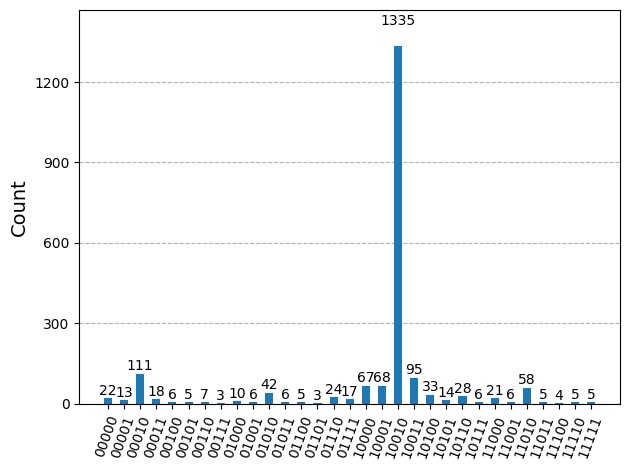

In [116]:
# repeat the same on the fake noisy backend
from qiskit_ibm_runtime.fake_provider import FakeKyiv
backend = FakeKyiv()
countD=runJob(qc,shots,backend) 
eval_x(countD)
plot_histogram(countD)